## Project 5
by Jiangyong Huang on Dec 20, 2022

**Integrating Generative and Descriptive Model**

Generative model augmented with latent space modeled by Descriptive EBM

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.utils import make_grid
%matplotlib inline
torch.manual_seed(1220)
torch.cuda.manual_seed(1220)

Configs

In [2]:
class Config(object):
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.langevin_steps = 20
        self.langevin_step_size = 0.1
        self.sigma = 1
        self.prior_sigma = 1
        self.epochs = 3000
        self.lr = 1e-3
        self.interpolation_d = 5
        self.z_dim = 32

args = Config()

Dataset

In [3]:
def load_data(data_dir='images'):
    imgs = []
    transform = T.Compose([T.Resize([128, 128]), T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    for fname in os.listdir(data_dir):
        img = Image.open(os.path.join(data_dir, fname)).convert('RGB')
        img = transform(img)
        imgs.append(img)
    
    imgs = torch.stack(imgs)
    return imgs

Model

In [4]:
def set_cuda(deterministic=True):
    if torch.cuda.is_available():
        if deterministic:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        else:
            torch.backends.cudnn.deterministic = False
            torch.backends.cudnn.benchmark = True


def make_upsample_block(in_dim, out_dim, is_last=False):
    if is_last:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_dim, out_channels=out_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=out_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_dim, out_channels=3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_dim, out_channels=out_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=out_dim),
            nn.ReLU(inplace=True)
        )


class DesNet(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        """
        Instead of encoding image to latent like VAE,
        this descriptor directly models the prior distribution of latent variable z.
        """
        super().__init__()
        self.layer1 = nn.Linear(z_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 1)

    def forward(self, z):
        z = z.to(self.layer1.weight.device)
        x = self.layer1(z)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x.squeeze(-1)


class GenNet(nn.Module):
    def __init__(self, z_dim):
        """
        Decode latent variable z to form an output image at 128x128.
        The latent z is first projected to feature map at 2x2, which further goes through transposed conv to 128x128.
        (z_dim) -> (512, 4, 4) -> (512, 8, 8) -> (256, 16, 16) -> (128, 32, 32) -> (64, 64, 64) -> (3, 128, 128)
        """
        super().__init__()
        self.z_proj = nn.Linear(z_dim, 512*4*4)
        self.block1 = make_upsample_block(in_dim=512, out_dim=512, is_last=False)
        self.block2 = make_upsample_block(in_dim=512, out_dim=256, is_last=False)
        self.block3 = make_upsample_block(in_dim=256, out_dim=128, is_last=False)
        self.block4 = make_upsample_block(in_dim=128, out_dim=64, is_last=False)
        self.block5 = make_upsample_block(in_dim=64, out_dim=64, is_last=True)

    def forward(self, z):
        # [-1, z_dim]
        z = z.to(self.z_proj.weight.device)
        x = self.z_proj(z)
        # [-1, 8192]
        x = x.view(-1, 512, 4, 4)
        x = self.block1(x)
        # [-1, 512, 8, 8]
        x = self.block2(x)
        # [-1, 256, 16, 16]
        x = self.block3(x)
        # [-1, 128, 32, 32]
        x = self.block4(x)
        # [-1, 64, 64, 64]
        x = self.block5(x)
        # [-1, 3, 128, 128]
        return x


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.xavier_normal_(m.weight)
    elif 'BatchNorm' in classname:
        m.weight.data.normal_(1, 0.02)
        m.bias.data.fill_(0)


class Model(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.langevin_steps = args.langevin_steps
        self.langevin_step_size = args.langevin_step_size
        self.sigma = args.sigma
        self.prior_sigma = args.prior_sigma
        self.lr = args.lr

        self.Generator = GenNet(z_dim=args.z_dim)
        self.Generator.apply(weights_init_xavier)
        self.Generator.to(args.device)

        self.Descriptor = DesNet(z_dim=args.z_dim, hidden_dim=2*args.z_dim)
        self.Descriptor.apply(weights_init_xavier)
        self.Descriptor.to(args.device)

    def sample_langevin_prior(self, z):
        # prior p(z)
        for i in range(self.langevin_steps):
            z = z.detach()
            z.requires_grad = True

            prior_log_likelihood = self.Descriptor(z) - (z**2).sum() / (2 * self.prior_sigma**2)
            z_grad_descriptor = torch.autograd.grad(prior_log_likelihood, z)[0]

            grad = z_grad_descriptor.clone()
            norm = torch.linalg.norm(grad)
            if norm > 1:
                grad /= norm
            noise = torch.randn_like(z, device=z.device)
            z = z + self.langevin_step_size**2 * grad / 2 + self.langevin_step_size * noise
        
        return z.detach()
    
    def sample_langevin_post(self, z, I):
        # posterior p(z|I) \propto p(z)p(I|z)
        for i in range(self.langevin_steps):
            z = z.detach()
            z.requires_grad = True

            prior_log_likelihood = self.Descriptor(z) - (z**2).sum() / (2 * self.prior_sigma**2)
            z_grad_descriptor = torch.autograd.grad(prior_log_likelihood, z)[0]

            g = self.Generator(z)
            cond_log_likelihood = -F.mse_loss(g.squeeze(), I.to(g.device), reduction='sum') / (2 * self.sigma**2)
            z_grad_generator = torch.autograd.grad(cond_log_likelihood, z)[0]

            grad = z_grad_descriptor + z_grad_generator
            norm = torch.linalg.norm(grad)
            if norm > 1:
                grad /= norm
            noise = torch.randn_like(z, device=z.device)

            z = z + self.langevin_step_size**2 * grad / 2 + self.langevin_step_size * noise
        
        return z.detach()

    def update(self, zs_prior, zs_post, imgs):
        """
        latents: [N, z_dim]
        imgs: [N, 3, 128, 128]
        """
        named_grads = {}
        zs_prior_new = []
        zs_post_new = []
        energy_pos = []
        energy_neg = []
        loss_generator = []
        for z_prior, z_post, I in zip(zs_prior, zs_post, imgs):
            z_prior = self.sample_langevin_prior(z_prior)
            z_post = self.sample_langevin_post(z_post, I)

            self.Descriptor.zero_grad()
            score_pos = self.Descriptor(z_post)
            score_neg = self.Descriptor(z_prior)
            score_descriptor = score_pos - score_neg
            score_descriptor.backward()

            self.Generator.zero_grad()
            g = self.Generator(z_post)
            score_generator = -F.mse_loss(g.squeeze(), I.to(g.device), reduction='sum') / (2 * self.sigma**2)
            score_generator.backward()
            
            # collect gradients
            for n, p in self.named_parameters():
                if n not in named_grads.keys():
                    named_grads.update({n: []})
                named_grads[n].append(p.grad.clone())
            
            zs_prior_new.append(z_prior.view(-1, z_prior.numel()))
            zs_post_new.append(z_post.view(-1, z_post.numel()))
            # record loss
            energy_pos.append(-score_pos.detach().item())
            energy_neg.append(-score_neg.detach().item())
            loss_generator.append(-score_generator.detach().item())

        # update parameters
        for n, p in self.named_parameters():
            grad = torch.stack(named_grads[n], dim=0).mean(0)
            norm = torch.linalg.norm(grad)
            if norm > 1:
                grad /= norm
            p.data += self.lr * grad

        return torch.cat(zs_prior_new, dim=0).detach(), torch.cat(zs_post_new, dim=0).detach(), \
               np.mean(energy_pos), np.mean(energy_neg), np.mean(loss_generator)

Visualization tools

In [5]:
@torch.no_grad()
def sample_img(model, z):
    sample = model.Generator(z)
    sample = sample.squeeze().detach().cpu().numpy()
    # [-1, 1] to [0, 1]
    sample = (sample + 1) / 2
    # [C, H, W] to [H, W, C]
    sample = sample.transpose(1, 2, 0)
    return sample


def visualize_img_tensor(img_tensor, title_str):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img_array = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    if img_array.mean() > 1:
        img_array = (img_array / 255).clip(0, 1)
    else:
        img_array = img_array.clip(0, 1)
    plt.figure()
    plt.imshow(img_array)
    plt.title(title_str)
    plt.axis('off')


@torch.no_grad()
def show_interpolation(model, z_dim, d):
    # make 10x10 grids from interpolation within [-d, d] in latent space
    inter_range = torch.linspace(-d, d, 10)
    xs, ys = torch.meshgrid([inter_range, inter_range], indexing='xy')
    latents = torch.zeros(100, z_dim)
    latents[:, :2] = torch.stack([xs, ys], dim=-1).reshape(-1, 2)   # interpolate on the first 2 dims
    samples = model.Generator(latents)
    samples = (samples + 1) / 2
    vis_grid = make_grid(samples, nrow=10)
    visualize_img_tensor(vis_grid, 'Interpolation in latent space')


def visualize_curve(losses, energy_pos_list, energy_neg_list):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Loss over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(energy_pos_list, label='positive')
    plt.plot(energy_neg_list, label='negative')
    plt.title('Energy over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.legend()
    plt.tight_layout()


def visualize_samples(model, zs_post, imgs):
    z_random = torch.randn_like(zs_post[0])
    nearest_idx = torch.linalg.norm(zs_post-z_random, dim=-1).argmin()
    z_warm = zs_post[nearest_idx]
    I = imgs[nearest_idx]

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(sample_img(model, z_random))
    plt.title('Random sample')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    z_cold = model.sample_langevin_post(z_random, I)
    plt.imshow(sample_img(model, z_cold))
    plt.title('Posterior cold')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    z_warm = model.sample_langevin_post(z_warm, I)
    plt.imshow(sample_img(model, z_warm))
    plt.title('Posterior warm')
    plt.axis('off')
    plt.tight_layout()

Experiment

For each setting z_dim = {2, 8, 32}, train the descriptor and generator by alternating backpropagation in warm start scheme. After finishing the epochs, show experimental results in three part:

- Visualize the curves of loss and positive/negative energy

- Display the synthesized images from random sample, cold start and warm start respectively

- Probe the interpolation in latent space, where we make 10x10 grids on the first 2 dimensions of latent space

In [6]:
def run(args):
    imgs = load_data()
    print(f'Loaded {len(imgs)} images')
    z_dim = args.z_dim
    zs_prior = torch.randn(len(imgs), z_dim)
    zs_post = torch.randn(len(imgs), z_dim)
    model = Model(args)
    energy_pos_list = []
    energy_neg_list = []
    losses = []
    for i in range(args.epochs):
        zs_prior, zs_post, energy_pos, energy_neg, loss = model.update(zs_prior, zs_post, imgs)
        losses.append(loss)
        energy_pos_list.append(energy_pos)
        energy_neg_list.append(energy_neg)
        if (i+1) % 10 == 0:
            print(f'Epoch {i+1} loss: {loss:.4f}')
    
    visualize_curve(losses, energy_pos_list, energy_neg_list)
    
    visualize_samples(model, zs_post, imgs)

    show_interpolation(model, z_dim, args.interpolation_d)

z_dim = 2

Loaded 11 images
Epoch 10 loss: 10645.5254
Epoch 20 loss: 10073.0157
Epoch 30 loss: 9583.7870
Epoch 40 loss: 9218.1420
Epoch 50 loss: 8888.1559
Epoch 60 loss: 8642.3575
Epoch 70 loss: 8403.2690
Epoch 80 loss: 8183.9230
Epoch 90 loss: 7962.8893
Epoch 100 loss: 7735.9093
Epoch 110 loss: 7524.6467
Epoch 120 loss: 7383.6735
Epoch 130 loss: 7120.1247
Epoch 140 loss: 6945.4719
Epoch 150 loss: 6719.0732
Epoch 160 loss: 6570.2642
Epoch 170 loss: 6345.5063
Epoch 180 loss: 6249.9855
Epoch 190 loss: 6124.1268
Epoch 200 loss: 5976.2718
Epoch 210 loss: 5784.8569
Epoch 220 loss: 5648.9274
Epoch 230 loss: 5539.6311
Epoch 240 loss: 5390.8978
Epoch 250 loss: 5258.7123
Epoch 260 loss: 5169.9640
Epoch 270 loss: 5002.8390
Epoch 280 loss: 4936.5046
Epoch 290 loss: 4810.5665
Epoch 300 loss: 4715.6262
Epoch 310 loss: 4697.1566
Epoch 320 loss: 4591.4579
Epoch 330 loss: 4510.5814
Epoch 340 loss: 4444.7629
Epoch 350 loss: 4410.0995
Epoch 360 loss: 4312.4395
Epoch 370 loss: 4274.0217
Epoch 380 loss: 4205.3011
Ep

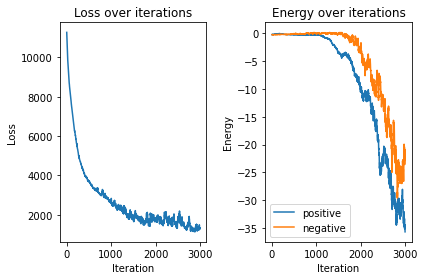

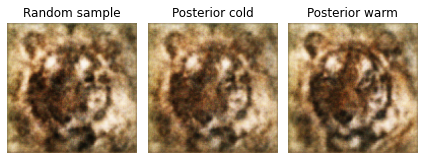

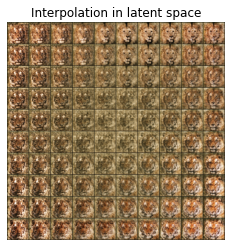

In [7]:
setattr(args, 'z_dim', 2)
run(args)

z_dim = 8

Loaded 11 images
Epoch 10 loss: 10351.4913
Epoch 20 loss: 9789.6611
Epoch 30 loss: 9331.0901
Epoch 40 loss: 8965.5679
Epoch 50 loss: 8642.0639
Epoch 60 loss: 8384.2365
Epoch 70 loss: 8174.0254
Epoch 80 loss: 7966.3216
Epoch 90 loss: 7790.9810
Epoch 100 loss: 7618.4604
Epoch 110 loss: 7453.7207
Epoch 120 loss: 7310.3095
Epoch 130 loss: 7132.0281
Epoch 140 loss: 6976.0516
Epoch 150 loss: 6800.8930
Epoch 160 loss: 6637.1368
Epoch 170 loss: 6505.5512
Epoch 180 loss: 6351.1966
Epoch 190 loss: 6206.6371
Epoch 200 loss: 6071.8955
Epoch 210 loss: 5937.0407
Epoch 220 loss: 5804.9421
Epoch 230 loss: 5674.3318
Epoch 240 loss: 5539.9447
Epoch 250 loss: 5415.7275
Epoch 260 loss: 5306.7323
Epoch 270 loss: 5198.3362
Epoch 280 loss: 5077.7666
Epoch 290 loss: 4981.4128
Epoch 300 loss: 4901.3811
Epoch 310 loss: 4813.4779
Epoch 320 loss: 4715.1450
Epoch 330 loss: 4628.6244
Epoch 340 loss: 4556.9697
Epoch 350 loss: 4477.8588
Epoch 360 loss: 4418.5040
Epoch 370 loss: 4339.6450
Epoch 380 loss: 4279.8129
Epo

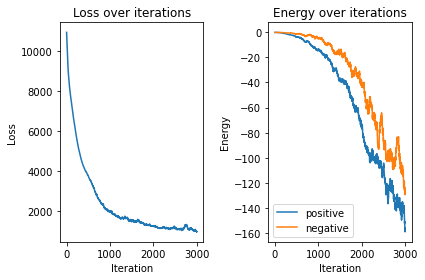

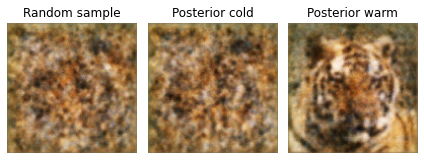

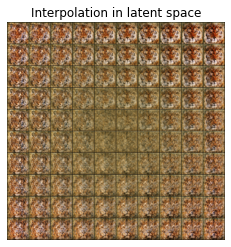

In [8]:
setattr(args, 'z_dim', 8)
run(args)

z_dim = 32

Loaded 11 images
Epoch 10 loss: 10264.5957
Epoch 20 loss: 9719.8509
Epoch 30 loss: 9258.0228
Epoch 40 loss: 8897.4096
Epoch 50 loss: 8641.4690
Epoch 60 loss: 8412.2803
Epoch 70 loss: 8228.8242
Epoch 80 loss: 8053.0207
Epoch 90 loss: 7873.2373
Epoch 100 loss: 7690.3029
Epoch 110 loss: 7521.9621
Epoch 120 loss: 7352.3430
Epoch 130 loss: 7187.2573
Epoch 140 loss: 7041.3908
Epoch 150 loss: 6877.6409
Epoch 160 loss: 6718.0569
Epoch 170 loss: 6569.6394
Epoch 180 loss: 6431.7974
Epoch 190 loss: 6289.1866
Epoch 200 loss: 6152.7978
Epoch 210 loss: 6018.4960
Epoch 220 loss: 5885.1405
Epoch 230 loss: 5767.2153
Epoch 240 loss: 5637.2656
Epoch 250 loss: 5512.9186
Epoch 260 loss: 5406.7713
Epoch 270 loss: 5298.8986
Epoch 280 loss: 5187.6329
Epoch 290 loss: 5090.7018
Epoch 300 loss: 4992.7543
Epoch 310 loss: 4907.5509
Epoch 320 loss: 4828.1025
Epoch 330 loss: 4750.3995
Epoch 340 loss: 4673.2170
Epoch 350 loss: 4598.0694
Epoch 360 loss: 4527.0781
Epoch 370 loss: 4459.3821
Epoch 380 loss: 4397.9230
Epo

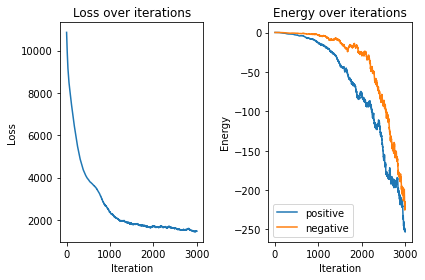

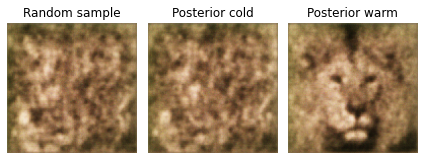

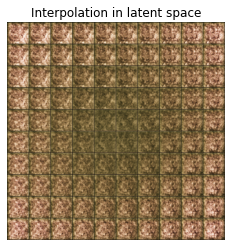

In [9]:
setattr(args, 'z_dim', 32)
run(args)